In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn

from trainer import Trainer

### Utility Functions

In [2]:
def get_device():
    """Get available device"""

    if torch.cuda.is_available():
        print("Using CUDA...")
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print("Using MPS...")
        return torch.device("mps")
    else:
        print("Using CPU...")
        return torch.device("cpu")

def imshow(img):
    """Display CIFAR10 image"""
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
# setup device
device = get_device()

Using MPS...


### Load CIFAR-10 dataset

In [4]:
BATCH_SIZE = 256

train_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)

# split into 80-20 train and validation dataset
train_set, val_set = torch.utils.data.random_split(train_set, [0.90, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Input Tensor: torch.Size([3, 32, 32])
Label: 4


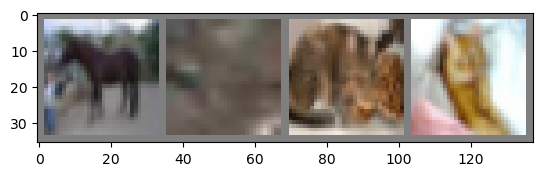

horse frog  cat   cat  


In [5]:
# get one sample
images, labels = train_set[0]

print(f"Input Tensor: {images.shape}")
print(f"Label: {labels}")

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Training Existing ResNet-18 Model
We will call PyTorch's existing implementation the baseline model

In [6]:
baseline_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# drop last linear layer and fit new linear layer for CIFAR-10
baseline_net.fc = nn.Linear(in_features=512, out_features=10)
baseline_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# setup trainer class to fine-tune ResNet-18
baseline_trainer = Trainer(baseline_net, model_name="baseline_pytorch_resnet18", batch_size=BATCH_SIZE, device=device)
baseline_trainer.train(train_dataloader, val_dataloader)

100%|██████████| 176/176 [00:33<00:00,  5.27it/s, loss=1.07]


INFO | [EPOCH 1] LOSS : train=1.2927791320464828 val=1.089158946275711 | ACCURACY : train=0.5494868755340576 val=0.6239315271377563


100%|██████████| 176/176 [00:27<00:00,  6.46it/s, loss=0.947]


INFO | [EPOCH 2] LOSS : train=0.9792132143947211 val=0.9988020181655883 | ACCURACY : train=0.6559889912605286 val=0.6533777713775635


100%|██████████| 176/176 [00:26<00:00,  6.60it/s, loss=0.892]


INFO | [EPOCH 3] LOSS : train=0.9007515595717863 val=0.8993528574705124 | ACCURACY : train=0.6849262714385986 val=0.683789074420929


100%|██████████| 176/176 [00:26<00:00,  6.52it/s, loss=0.84] 


INFO | [EPOCH 4] LOSS : train=0.8523990488187834 val=0.8426514118909836 | ACCURACY : train=0.7048038244247437 val=0.7145565152168274


100%|██████████| 176/176 [00:28<00:00,  6.09it/s, loss=0.839]


INFO | [EPOCH 5] LOSS : train=0.8106561794199727 val=0.8479124873876571 | ACCURACY : train=0.7189772725105286 val=0.7079733610153198


100%|██████████| 176/176 [00:26<00:00,  6.55it/s, loss=0.777]


INFO | [EPOCH 6] LOSS : train=0.7867009382356297 val=0.8408827185630798 | ACCURACY : train=0.7253142595291138 val=0.7053309082984924


100%|██████████| 176/176 [00:27<00:00,  6.49it/s, loss=0.787]


INFO | [EPOCH 7] LOSS : train=0.7633761021901261 val=0.803365695476532 | ACCURACY : train=0.733961284160614 val=0.7221622467041016


100%|██████████| 176/176 [00:26<00:00,  6.63it/s, loss=0.725]


INFO | [EPOCH 8] LOSS : train=0.7047362510453571 val=0.7335725009441376 | ACCURACY : train=0.7528968453407288 val=0.7420496344566345


100%|██████████| 176/176 [00:28<00:00,  6.24it/s, loss=0.65] 


INFO | [EPOCH 9] LOSS : train=0.6783253933218393 val=0.724854588508606 | ACCURACY : train=0.7632173299789429 val=0.7494140863418579


100%|██████████| 176/176 [00:28<00:00,  6.18it/s, loss=0.656]


INFO | [EPOCH 10] LOSS : train=0.6568426726893946 val=0.7254648029804229 | ACCURACY : train=0.7684428691864014 val=0.7468290328979492


100%|██████████| 176/176 [00:28<00:00,  6.16it/s, loss=0.669]


INFO | [EPOCH 11] LOSS : train=0.6518121432851661 val=0.7390782803297042 | ACCURACY : train=0.7736364006996155 val=0.7474379539489746


100%|██████████| 176/176 [00:28<00:00,  6.17it/s, loss=0.635]


INFO | [EPOCH 12] LOSS : train=0.6489648189057003 val=0.717207407951355 | ACCURACY : train=0.7744389176368713 val=0.7468864917755127


100%|██████████| 176/176 [00:30<00:00,  5.85it/s, loss=0.637]


INFO | [EPOCH 13] LOSS : train=0.6468294980851087 val=0.7182661861181259 | ACCURACY : train=0.7727903127670288 val=0.754721999168396


100%|██████████| 176/176 [00:30<00:00,  5.78it/s, loss=0.616]


INFO | [EPOCH 14] LOSS : train=0.6377064775336873 val=0.7355333685874939 | ACCURACY : train=0.7783727049827576 val=0.7487247586250305


100%|██████████| 176/176 [00:30<00:00,  5.82it/s, loss=0.627]


INFO | [EPOCH 15] LOSS : train=0.6310658798637715 val=0.6746582716703415 | ACCURACY : train=0.7795401215553284 val=0.7662339210510254


 32%|███▏      | 57/176 [00:06<00:13,  8.80it/s, loss=0.645]

In [ ]:
baseline_trainer.test(test_dataloader)
baseline_trainer.plot_metrics()

### Training My PyTorch Implementation of ResNet-18

In [ ]:
from resnet18 import ResNet18

resnet = ResNet18.from_pretrained("resnet18")
print("lfg, we didn't crash!")
resnet_trainer = Trainer(resnet, device=device)
resnet_trainer.train(train_dataloader, val_dataloader)

In [ ]:
resnet_trainer.test(test_dataloader)
resnet_trainer.plot_metrics()

# Acknowledgements

- [PyTorch CIFAR10 Training Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [A Detailed Introduction to ResNet and Its Implementation in PyTorch](https://medium.com/@freshtechyy/a-detailed-introduction-to-resnet-and-its-implementation-in-pytorch-744b13c8074a) by Huili Yu
- [Let's reproduce GPT-2 (124M)](https://www.youtube.com/watch?v=l8pRSuU81PU) by Andrej Karpathy
- [Helpful conventions for PyTorch model building](https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md) by FrancescoSaverioZuppichini  